# Body curve ANOVA and posthoc by plate
Conny Lin | May 3, 2020 | updated: May 9, 2020

In [104]:
# - plan - 
# get csv by plate
# export descriptive csv for excel graphing
# transform to anova input
# run anova
# run posthoc
# put in table
# visualize differences between groups

In [105]:
# import library
# import libraries
import os
import re as re
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm #used for plotting
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import multicomp
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [106]:
# functions
def report_stats_apa(stattype,dfreedom,testresult,pvalue,plimit=0.001,alpha=0.05):
    if pvalue<plimit:
        stat_report_str = print(f'{stattype}({dfreedom:.0f}) = {testresult:.3f}, p < {plimit}')
    elif p>alpha:
        stat_report_str = print(f'{stattype}({dfreedom:.0f}) = {testresult:.3f}, p = n.s.')
    else:
        stat_report_str = print(f'{stattype}({dfreedom:.0f}) = {testresult:.3f}, p = {pvalue:.3f}')
    return stat_report_str

In [107]:
def convert_statsmodel_table2dataframe(statsmodel_object):
    column_names = statsmodel_object.data[0]
    d = statsmodel_object.data[1:]
    statsmodel_object_dataframe = pd.DataFrame(d,columns=column_names)
    return statsmodel_object_dataframe

## work

In [108]:
# set working dir
working_dir = '/Users/connylin/Dropbox/CA/CA Publications/Manuscript RL Alcohol hab model slo1/3-Results/Fig1 WT speed and curve before training dose/basal_response_by_exp_20200418/'

In [109]:
# global variable
alpha = 0.05
pvlimit = 0.001

In [110]:
# get csv by plate
p = os.path.join(working_dir, 'desc_stats_by_plate.csv')
df = pd.read_csv(p)
df.head()

,expyear,expname,groupname,mwtname,wormN,speed,speed_SE,curve,curve_SE
0,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_100mM,20120213_154120,9,0.307969,0.019229,26.808175,0.615400
1,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_100mM,20120213_155059,15,0.264298,0.016657,31.725721,0.972318
2,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_100mM,20120213_155939,24,0.285712,0.013011,30.255534,0.387169
3,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_100mM,20120213_161324,25,0.362677,0.015299,29.494326,0.535562
4,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_200mM,20120213_162924,26,0.299793,0.015675,24.495509,0.705827


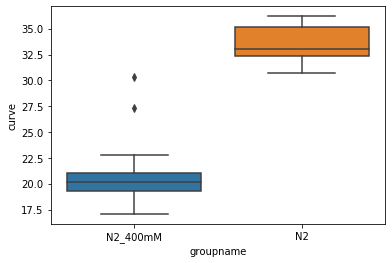

In [111]:
# look at what's wrong with 400mM
rows_ind = (df['groupname'] == 'N2') | (df['groupname'] == 'N2_400mM')
col_ind = ['groupname','curve','curve_SE']
df_400mM = df.loc[rows_ind, col_ind]
# graph
sns.boxplot(x='groupname',y='curve',data=df_400mM)

In [112]:
# find the two outliers in 400mM
df_400mM.loc[df_400mM['groupname']=='N2_400mM'].sort_values(by=['curve'], ascending=False)

,groupname,curve,curve_SE
61,N2_400mM,30.294571,0.737792
49,N2_400mM,27.348028,0.420538
29,N2_400mM,22.786661,1.123987
96,N2_400mM,21.646205,0.755274
67,N2_400mM,20.506319,0.432525
30,N2_400mM,20.418954,0.903061
82,N2_400mM,20.380902,0.579628
55,N2_400mM,20.175324,0.522992
90,N2_400mM,20.026409,0.697018
95,N2_400mM,19.689020,0.556422


In [113]:
# get the index 61 and 49 out
df.drop([61, 49],axis=0, inplace=True)

In [114]:
# export descriptive csv for excel graphing
df1 = df.groupby('groupname').aggregate({'curve':['mean','sem','count']})
df1.to_csv(os.path.join(working_dir,'curve_desc_bygroup_Nplate_exclude_outlier.csv'))
display(df1)
del df1

curve                
                mean       sem count
groupname                           
N2         33.451397  0.440895    16
N2_100mM   29.546363  0.413260    15
N2_200mM   25.217900  0.500423    20
N2_300mM   22.180410  0.491802    15
N2_400mM   19.810690  0.419364    13
N2_500mM   19.166218  0.415679    16
N2_600mM   19.390700  0.425215     8

In [115]:
# transform to anova input - no need. already in the format

In [116]:
# run anova
df_lm = ols('curve ~ groupname', data=df).fit()
anovaT = anova_lm(df_lm)
display(anovaT)

,df,sum_sq,mean_sq,F,PR(>F)
groupname,6.0,2703.693207,450.615535,140.679474,2.714985e-45
Residual,96.0,307.501088,3.203136,NaN,NaN


In [117]:
# export anova table
anovaT.to_csv(os.path.join(working_dir,'curve_desc_bygroup_Nplate_anovatable_dropoutlier.csv'))

In [118]:
# get anova written report format
anova_apa = report_stats_apa('F',
                             anovaT.loc['groupname','df'],
                             anovaT.loc['groupname','F'],
                             anovaT.loc['groupname','PR(>F)'],
                             pvlimit,
                             alpha)
anova_apa

F(6) = 140.679, p < 0.001


In [119]:
# run posthoc
tukey = multicomp.pairwise_tukeyhsd(df['curve'], df['groupname']).summary()
tukey

group1,group2,meandiff,p-adj,lower,upper,reject
N2,N2_100mM,-3.905,0.001,-5.8422,-1.9679,True
N2,N2_200mM,-8.2335,0.001,-10.0414,-6.4256,True
N2,N2_300mM,-11.271,0.001,-13.2082,-9.3338,True
N2,N2_400mM,-13.6407,0.001,-15.6533,-11.6281,True
N2,N2_500mM,-14.2852,0.001,-16.1909,-12.3795,True
N2,N2_600mM,-14.0607,0.001,-16.3947,-11.7267,True
N2_100mM,N2_200mM,-4.3285,0.001,-6.1695,-2.4874,True
N2_100mM,N2_300mM,-7.366,0.001,-9.3341,-5.3978,True
N2_100mM,N2_400mM,-9.7357,0.001,-11.7781,-7.6932,True
N2_100mM,N2_500mM,-10.3801,0.001,-12.3173,-8.443,True


In [120]:
# put in table
tukey_df = convert_statsmodel_table2dataframe(tukey)
tukey_df.to_csv(os.path.join(working_dir,'curve_desc_bygroup_Nplate_tukeytable_dropoutlier.csv'))

In [121]:
# visualize differences between groups
# transform to seaborn heatmap input
tukey_df_pvalue_pivot = tukey_df.pivot(index='group1',columns='group2',values='p-adj')
tukey_df_pvalue_pivot

group2,N2_100mM,N2_200mM,N2_300mM,N2_400mM,N2_500mM,N2_600mM
group1,,,,,,
N2,0.001,0.001,0.001,0.0010,0.001,0.001
N2_100mM,NaN,0.001,0.001,0.0010,0.001,0.001
N2_200mM,NaN,NaN,0.001,0.0010,0.001,0.001
N2_300mM,NaN,NaN,NaN,0.0124,0.001,0.010
N2_400mM,NaN,NaN,NaN,NaN,0.900,0.900
N2_500mM,NaN,NaN,NaN,NaN,NaN,0.900


In [122]:
# mute n.s.
tukey_df_graphing = tukey_df_pvalue_pivot.mask(tukey_df_pvalue_pivot > alpha)
tukey_df_graphing

group2,N2_100mM,N2_200mM,N2_300mM,N2_400mM,N2_500mM,N2_600mM
group1,,,,,,
N2,0.001,0.001,0.001,0.0010,0.001,0.001
N2_100mM,NaN,0.001,0.001,0.0010,0.001,0.001
N2_200mM,NaN,NaN,0.001,0.0010,0.001,0.001
N2_300mM,NaN,NaN,NaN,0.0124,0.001,0.010
N2_400mM,NaN,NaN,NaN,NaN,NaN,NaN
N2_500mM,NaN,NaN,NaN,NaN,NaN,NaN


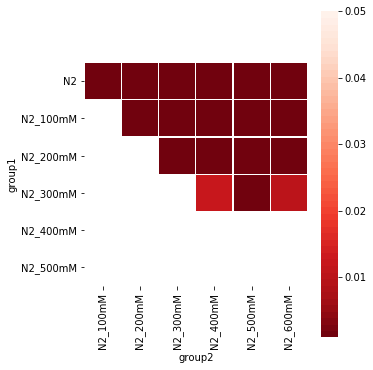

In [123]:
# visualize
plt.figure(figsize=(5,6))
cmap = sns.color_palette("Reds_r", 50)
sns.heatmap(tukey_df_graphing,cmap=cmap,square=True,linewidth=0.2,vmin=pvlimit,vmax=alpha)
plt.savefig(os.path.join(working_dir,'curve_desc_bygroup_Nplate_tukeytable_dropoutlier.jpeg'))

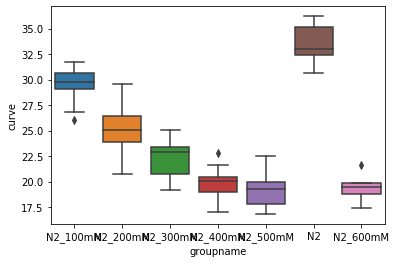

In [125]:
# bar chart
sns.boxplot(x='groupname',y='curve',data=df)